## IMPORT, CONFIG

In [1]:
import numpy as np
import tensorflow as tf
import tqdm, os
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as displayer
import math

class Config(object):
    pass
config = Config()
config.batch_size = 128
config.learning_rate = 0.1
config.use_float16 = False
config.data_path_dir = "../../datasets/cifar-100-binary"
config.BN_epsilon = 1e-5
config.BN_decay = 0.995

In [2]:
class Dataset():
    def __init__(self, batch_size = config.batch_size):
        self.width = 32
        self.height = 32
        self.depth = 3
        self.x_train, self.y_train = None, None
        self.x_test, self.y_test = None, None
        self.batch_size = batch_size
        self.num_classes = 100
        
    def readData(self, path, is_one_hot = True):
        def combineChannels(t, m):
            r = t[:, 2:1026].reshape((m, 1024, 1))
            g = t[:, 1026:2050].reshape((m, 1024, 1))
            b = t[:, 2050:].reshape((m, 1024, 1))
            return np.dstack((r, g, b)).reshape((m, 32, 32, 3))
        
        with open(os.path.join(path, "train.bin"), mode='rb') as file:
            t = np.fromfile(file, dtype = np.uint8).reshape(50000, -1)
            file.close()
            self.y_train = t[:, 1]
            self.x_train = combineChannels(t, 50000) / 255
        
        self.start_batch_index = self.end_batch_index = self.num_train_images = np.shape(self.y_train)[0]
        
        with open(os.path.join(path, "test.bin"), mode='rb') as file:
            t = np.fromfile(file, dtype = np.uint8).reshape(10000, -1)
            self.y_test = t[:, 1]
            self.x_test = combineChannels(t, 10000) / 255
        
    def get_next_batch(self):
        if self.end_batch_index >= self.num_train_images:
            #suffle
            self.suffle()
            self.start_batch_index = 0
            self.end_batch_index = self.batch_size
        
        batch_x = self.x_train[self.start_batch_index : self.end_batch_index].astype(
            np.float16 if config.use_float16 else np.float32)
        batch_y = self.y_train[self.start_batch_index : self.end_batch_index]
        self.start_batch_index = self.end_batch_index
        self.end_batch_index += self.batch_size
        
        return (batch_x, batch_y)
    
    
    def suffle(self, is_training = True):
        if is_training:
            perm = np.random.permutation(self.num_train_images)
            self.x_train = self.x_train[perm]
            self.y_train = self.y_train[perm]
        else:
            perm = np.random.permutation(10000)
            self.x_test = self.x_test[perm]
            self.y_test = self.y_test[perm]
            
            
dataset = Dataset()
dataset.readData(config.data_path_dir, is_one_hot = False)

## BUILD GRAPHS

In [4]:
def batch_norm_wrapper(x, is_training):
    """
    is_training: a boolean tensor
    """
    with tf.variable_scope('batch_norm') as scope:
        gamma = tf.Variable(tf.ones([x.get_shape()[-1]]), trainable = True)
        beta  = tf.Variable(tf.zeros([x.get_shape()[-1]]), trainable = True)
        pop_mean = tf.Variable(tf.zeros([x.get_shape()[-1]]), trainable=False, name = "pop_mean")
        pop_var  = tf.Variable(tf.constant(1.0, shape = [x.get_shape()[-1]]), trainable=False, name = "pop_var")

    def using_batch_statistics():
        batch_mean, batch_var = tf.nn.moments(x,[0])
        train_mean = tf.assign(pop_mean,
                               pop_mean * config.BN_decay + batch_mean * (1 - config.BN_decay))
        train_var = tf.assign(pop_var,
                              pop_var * config.BN_decay + batch_var * (1 - config.BN_decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(x,
                batch_mean, batch_var, beta, gamma, config.BN_epsilon)
    def using_global_statistics():
        return tf.nn.batch_normalization(x,
            pop_mean, pop_var, beta, gamma, config.BN_epsilon)
    
    return tf.cond(is_training, 
                   using_batch_statistics, 
                   using_global_statistics)


def batch_norm_wrapper_cnn(x, n_out, is_training):
    with tf.variable_scope('batch_norm'):
        xs = x.get_shape()
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                    name = 'beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                     name = 'gamma', trainable=True)
        pop_mean = tf.Variable(tf.zeros([n_out]), trainable=False, name = "pop_mean")
        pop_var  = tf.Variable(tf.constant(1.0, shape = [n_out]), trainable=False, name = "pop_var")
        
    def using_batch_statistics():
        batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2])
        train_mean = tf.assign(pop_mean,
                               pop_mean * config.BN_decay + batch_mean * (1 - config.BN_decay))
        train_var  = tf.assign(pop_var,
                               pop_var * config.BN_decay + batch_var * (1 - config.BN_decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(x,
                batch_mean, batch_var, beta, gamma, config.BN_epsilon)
        
    def using_global_statistics():
        return tf.nn.batch_normalization(x,
            pop_mean, pop_var, beta, gamma, config.BN_epsilon)
    
    return tf.cond(is_training, 
                   using_batch_statistics, 
                   using_global_statistics)

def variable_on_gpu(name, shape, initializer):
    with tf.device('/gpu:0'):
        dtype = tf.float16 if config.use_float16 else tf.float32
        var = tf.get_variable(name, shape, initializer=initializer, dtype=dtype)
    return var

def variable_with_weight_decay(name, shape, stddev, wd):
    dtype = tf.float16 if config.use_float16 else tf.float32
    var = variable_on_gpu(
        name,
        shape,
        tf.truncated_normal_initializer(stddev=stddev, dtype=dtype))
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var

In [5]:
def build_graph(is_using_BN = True, is_using_dropout = False):
    """define place holder"""
    dtype = tf.float16 if config.use_float16 else tf.float32
    x = tf.placeholder(dtype, shape=[None, dataset.height, dataset.width, dataset.depth])
    y = tf.placeholder(tf.int32)
    is_training = tf.placeholder(tf.bool)
    keep_prob = tf.placeholder(tf.float32)
    weight_decay = 0.001
    global_step = tf.Variable(0, trainable=False)
    
    """1st convolution layer"""
    with tf.variable_scope('conv1_1') as scope:
        kernel = variable_with_weight_decay('weights', 
                                             shape = [3, 3, 3, 32], 
                                             stddev = np.sqrt(1 / (3 * 3 * 3)), 
                                             wd = weight_decay)
        conv1_1 = tf.nn.conv2d(x, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv1_1 = batch_norm_wrapper_cnn(conv1_1, 32, is_training, global_step)
        else:
            biases = variable_on_gpu('biases', 32, tf.constant_initializer(0.01))
            conv1_1 = tf.add(conv1_1, biases)
        conv1_1 = tf.nn.relu(conv1_1)
    
    
    """2nd convolution layer"""
    with tf.variable_scope('conv1_2') as scope:
        kernel = variable_with_weight_decay('weights', 
                                             shape = [3, 3, 32, 32], 
                                             stddev = np.sqrt(2 / (3 * 3 * 32)), 
                                             wd = weight_decay)
        conv1_2 = tf.nn.conv2d(conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv1_2 = batch_norm_wrapper_cnn(conv1_2, 32, is_training, global_step)
        else:
            biases = variable_on_gpu('biases', 32, tf.constant_initializer(0.01))
            conv1_2 = tf.add(conv1_2, biases)
        conv1_2 = tf.nn.relu(conv1_2)
    
    
    """3rd convolution layer with max pooling"""
    with tf.variable_scope('conv1_3') as scope:
        kernel = variable_with_weight_decay('weights',
                                             shape = [3, 3, 32, 32],
                                             stddev = np.sqrt(2 / (3 * 3 * 32)),
                                             wd = weight_decay)
        
        conv1_3 = tf.nn.conv2d(conv1_2, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv1_3 = batch_norm_wrapper_cnn(conv1_3, 32, is_training, global_step)
        else:
            biases = variable_on_gpu('biases', 32, tf.constant_initializer(0.01))
            conv1_3 = tf.add(conv1_3, biases)
        conv1_3 = tf.nn.relu(conv1_3)
        
        pool1 = tf.nn.max_pool(conv1_3, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                         padding = 'SAME', name = 'pool2')
        
    
    """4th convolution layer"""
    with tf.variable_scope('conv2_1') as scope:
        kernel = variable_with_weight_decay('weights', 
                                             shape = [3, 3, 32, 64], 
                                             stddev = np.sqrt(1 / (3 * 3 * 32)), 
                                             wd = weight_decay)
        conv2_1 = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv2_1 = batch_norm_wrapper_cnn(conv2_1, 64, is_training, global_step)
        else:
            biases = variable_on_gpu('biases', 64, tf.constant_initializer(0.01))
            conv2_1 = tf.add(conv2_1, biases)
        conv2_1 = tf.nn.relu(conv2_1)
    
    
    """5th convolution layer"""
    with tf.variable_scope('conv2_2') as scope:
        kernel = variable_with_weight_decay('weights', 
                                             shape = [3, 3, 64, 64], 
                                             stddev = np.sqrt(2 / (3 * 3 * 64)), 
                                             wd = weight_decay)
        conv2_2 = tf.nn.conv2d(conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv2_2 = batch_norm_wrapper_cnn(conv2_2, 64, is_training, global_step)
        else:
            biases = variable_on_gpu('biases', 64, tf.constant_initializer(0.01))
            conv2_2 = tf.add(conv2_2, biases)
        conv2_2 = tf.nn.relu(conv2_2)
    
    
    """6th convolution layer with max pooling"""
    with tf.variable_scope('conv2_3') as scope:
        kernel = variable_with_weight_decay('weights',
                                             shape = [3, 3, 64, 64],
                                             stddev = np.sqrt(2 / (3 * 3 * 64)),
                                             wd = weight_decay)
        
        conv2_3 = tf.nn.conv2d(conv2_2, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv2_3 = batch_norm_wrapper_cnn(conv2_3, 64, is_training, global_step)
        else:
            biases = variable_on_gpu('biases', 64, tf.constant_initializer(0.01))
            conv2_3 = tf.add(conv2_3, biases)
        conv2_3 = tf.nn.relu(conv2_3)
        
        pool2 = tf.nn.max_pool(conv2_3, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                         padding = 'SAME', name = 'pool2')
        
    
    """7th convolution layer"""
    with tf.variable_scope('conv3_1') as scope:
        kernel = variable_with_weight_decay('weights', 
                                             shape = [3, 3, 64, 128], 
                                             stddev = np.sqrt(1 / (3 * 3 * 64)), 
                                             wd = weight_decay)
        conv3_1 = tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv3_1 = batch_norm_wrapper_cnn(conv3_1, 128, is_training, global_step)
        else:
            biases = variable_on_gpu('biases', 128, tf.constant_initializer(0.01))
            conv3_1 = tf.add(conv3_1, biases)
        conv3_1 = tf.nn.relu(conv3_1)
    
    
    """8th convolution layer"""
    with tf.variable_scope('conv3_2') as scope:
        kernel = variable_with_weight_decay('weights', 
                                             shape = [3, 3, 128, 128], 
                                             stddev = np.sqrt(2 / (3 * 3 * 128)), 
                                             wd = weight_decay)
        conv3_2 = tf.nn.conv2d(conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv3_2 = batch_norm_wrapper_cnn(conv3_2, 128, is_training, global_step)
        else:
            biases = variable_on_gpu('biases', 128, tf.constant_initializer(0.01))
            conv3_2 = tf.add(conv3_2, biases)
        conv3_2 = tf.nn.relu(conv3_2)
    
    
    """9th convolution layer with avg pooling"""
    with tf.variable_scope('conv3_3') as scope:
        conv3_3 = variable_with_weight_decay('weights',
                                             shape = [3, 3, 128, 128],
                                             stddev = np.sqrt(2 / (3 * 3 * 128)),
                                             wd = weight_decay)
        
        conv3_3 = tf.nn.conv2d(conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv3_3 = batch_norm_wrapper_cnn(conv3_3, 128, is_training, global_step)
        else:
            biases = variable_on_gpu('biases', 128, tf.constant_initializer(0.01))
            conv3_3 = tf.add(conv3_3, biases)
        conv3_3 = tf.nn.relu(conv3_3)
        
        pool3 = tf.nn.avg_pool(conv3_3, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1],
                         padding = 'SAME', name = 'pool9')
            
        pool3_flat = tf.reshape(pool3, [-1, 512])
    
    
#     """1st full connection layer"""
    with tf.variable_scope('fc1') as scope:        
        weights = variable_with_weight_decay('weights', 
                                             shape = [512, 512],
                                             stddev = np.sqrt(2 / (512)), 
                                             wd = weight_decay)
        fc1_logits = tf.matmul(pool3_flat, weights)
        if is_using_BN:
            fc1_logits = batch_norm_wrapper(fc1_logits, is_training, global_step)
        else:
            biases = variable_on_gpu('biases', [512], tf.constant_initializer(0.01))
            fc1_logits = tf.add(fc1_logits, biases, name = "logits")
        fc1_out = tf.nn.relu(fc1_logits, name = "after_activation")
        if is_using_dropout:
            fc1_out = tf.contrib.layers.dropout(fc1_out, keep_prob = 0.6, is_training = is_training)
    
    
    """softmax layer"""
    with tf.variable_scope('softmax') as scope:
        weights = variable_with_weight_decay(name = 'weights', 
                                             shape = [512, dataset.num_classes],
                                             stddev = np.sqrt(2 /(512)), 
                                             wd = weight_decay)
        biases = variable_on_gpu('biases', [dataset.num_classes], tf.constant_initializer(0.01))
        y_out = tf.add(tf.matmul(fc1_out, weights), biases, name = "output")

    
    """Loss, Optimizer and Predictions"""
    cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y, logits=y_out, name='cross_entropy'))
    tf.add_to_collection('losses', cross_entropy)
    total_loss = tf.add_n(tf.get_collection('losses'), name='total_loss')
    
    learning_rate = tf.maximum(tf.train.exponential_decay(config.learning_rate, global_step, 1000, 0.95, staircase=True),
                               0.01)
    
#     dw1 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, kernel1)))
#     dw5 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, kernel5)))
#     dw9 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, kernel9)))
    
#     do1 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, conv1)))
#     do5 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, conv5)))
#     do9 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, conv9)))


    trainer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(total_loss, global_step = global_step)

    correct_prediction = tf.equal(tf.cast(tf.arg_max(y_out, 1), tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return (x, y, is_training, keep_prob), trainer, accuracy, total_loss, y_out, tf.train.Saver()

## TRAIN NETWORKS

In [6]:
def train(is_using_BN = True,
          is_continue = False,
          model_name = None,
          current_step = 0,
          max_steps = 50000,
          eval_interval = 200,
          save_interval = 5000):
    
    graph = tf.Graph()
    with graph.as_default():
            (x_train, y_train, is_training, keep_prob), trainer, accuracy, loss, y_out, saver \
            = build_graph(is_using_BN = is_using_BN, is_using_dropout = True)
    
    if is_continue:
        """load something"""
        f = open(os.path.join(config.store_path, "losses.bin"), "rb")
        losses = np.fromfile(f, dtype = np.float32)
        f.close()
        f = open(os.path.join(config.store_path, "train_acc.bin"), "rb")
        train_acc = np.fromfile(f, dtype = np.float32)
        f.close()
        f = open(os.path.join(config.store_path, "test_acc.bin"), "rb")
        test_acc = np.fromfile(f, dtype = np.float32)
        f.close()
    else:
        losses, train_acc, test_acc = np.array([], dtype = np.float32), np.array([], dtype = np.float32), np.array([], dtype = np.float32)
    
    def evaluate(sess, num_examples = 10000, is_on_training_set = True): 
        accs, ls = [], []
        if is_on_training_set:
            prem = np.random.permutation(dataset.num_train_images)
            x = dataset.x_train[prem[:num_examples]]
            y = dataset.y_train[prem[:num_examples]]
        else:
            x = dataset.x_test[:num_examples]
            y = dataset.y_test[:num_examples]
        
        for i in range(0, num_examples, 1000):
            res = sess.run([accuracy, loss],
                           feed_dict = {x_train: x[i : i + 1000],
                                        y_train: y[i : i + 1000], 
                                        is_training: False,
                                       keep_prob : 1})
            accs.append(res[0])
            ls.append(res[1])
        
        return sum(accs) / len(accs), sum(ls) / len(ls)

    with tf.Session(graph = graph) as sess:
        if is_continue:
            if model_name is None:
                raise ValueError('Need the name of model')
            saver = tf.train.import_meta_graph(os.path.join(config.store_path, model_name + '.meta'))
            saver.restore(sess, os.path.join(config.store_path, model_name))
        else:
            sess.run(tf.global_variables_initializer())
        
        def save(arr, name):
            f = open(os.path.join(config.store_path, name+ ".bin"), "wb")
            arr.astype(np.float32).tofile(f)
            f.close()
        
        for i in tqdm.tqdm(range(current_step + 1, max_steps + 1)):
            batch = dataset.get_next_batch()
            _,l = sess.run([trainer, loss], \
                            feed_dict = {x_train : batch[0],
                                         y_train : batch[1],
                                         is_training : True,
                                         keep_prob: 0.6})

            if i % save_interval == 0:
                saved_model = saver.save(sess, config.store_path + 'model.ckpt', i)
                save(losses, 'losses')
                save(train_acc, 'train_acc')
                save(test_acc, 'test_acc')
                
            
            if i % eval_interval == 0:
                test_acc = np.append(test_acc, evaluate(sess, 10000, False)[0]).astype(np.float32)
                res = evaluate(sess)
                train_acc = np.append(train_acc, res[0])
                losses = np.append(losses, res[1])
                
                displayer.clear_output()
                print(test_acc[-1], train_acc[-1])
                plt.figure(1)
                plt.plot(range(0, i, eval_interval), train_acc, 'red', range(0, i, eval_interval), test_acc, 'blue')
                plt.figure(2)
                plt.plot(range(0, i, eval_interval), losses)
                plt.show()
                
        
    return losses, train_acc, test_acc

In [ ]:
config.learning_rate = 0.1
config.store_path = "../../models/CNN/cifar100/withoutBN/"
losses, train_acc, test_acc = train(is_using_BN = False)
''', is_continue = True, 
                                    model_name = 'model.ckpt-50000',
                                    current_step = 50000)'''

In [ ]:
config.learning_rate = 0.1
config.store_path = "../../models/CNN/cifar100/withBN/"
losses, train_acc, test_acc = train(is_using_BN = True)
''', is_continue = True, 
                                    model_name = 'model.ckpt-50000',
                                    current_step = 50000)'''

## PLOT

22


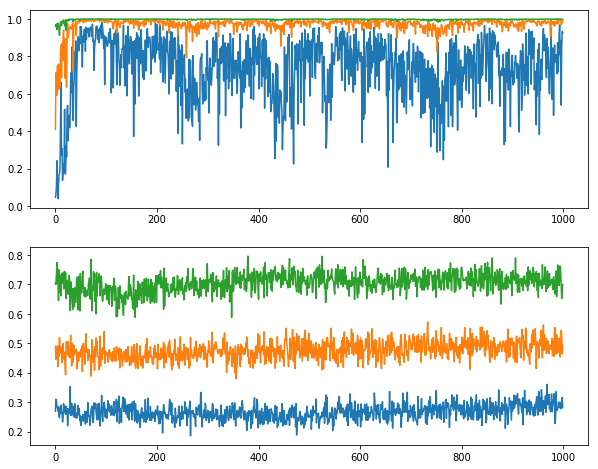

In [291]:
neuron = random.randint(0,99)
print(neuron)
z3s_dist, z3_BNs_dist = [], []

for z3 in Z3s:
    z3s_dist.append(np.percentile(z3[:,neuron], [15, 50, 85]))
    
for z3_BN in Z3_BNs:
    z3_BNs_dist.append(np.percentile(z3_BN[:,neuron], [15, 50, 85]))
    
z3s_dist = np.asarray(z3s_dist).T
z3_BNs_dist = np.asarray(z3_BNs_dist).T


fig= plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

#ax1.set_ylim([2,16])
#ax2.set_ylim([3,17])

ax1.plot(range(steps), z3s_dist[0], range(steps), z3s_dist[1], range(steps), z3s_dist[2])
ax2.plot(range(steps), z3_BNs_dist[0], range(steps), z3_BNs_dist[1], range(steps), z3_BNs_dist[2])
plt.show()

## RESTORE MODELS

In [18]:
#sess = tf.InteractiveSession()
#sess.close()

correct = []
graph = tf.Graph()
with graph.as_default():
    (x_eval, y_eval, is_training), _, accuracy, y_out, loss, saver_eval = build_graph(is_using_BN=True)

with tf.Session(graph = graph) as sess:
    for i in range(0, 2000, 500):
        saver_eval = tf.train.import_meta_graph('../../models/CNN/cifar100/withBN/model.ckpt-50000.meta')
        #sess.run(tf.global_variables_initializer())
        saver_eval.restore(sess, "../../models/CNN/cifar100/withBN/model.ckpt-50000")

        cor = sess.run([accuracy],
                       feed_dict={x_eval: dataset.x_train[i:i + 500] / 255.0, 
                                  y_eval: dataset.y_train[i:i + 500], 
                                  is_training: False})
        correct.append(cor[0])
        
print (sum(correct) / len(correct))

1.00000011921
